In [1]:
# Import Libraries
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, plot_tree
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

# Data import
df= pd.read_excel("C:\\Users\\rcmlp.12\\Desktop\\misc\\models hypertune\\Second_thursday_plan.xlsx")


C:\Users\rcmlp.12\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
C:\Users\rcmlp.12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\rcmlp.12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\rcmlp.12\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64I

In [2]:
df.head()

,DT,PIREP,OOS,CR,INT
0,202101,18,NaN,6,1
1,202101,10,96.0,22,1
2,202101,19,17.0,17,2
3,202101,20,57.0,12,1
4,202101,23,17.0,12,3


In [3]:
print(df.corr())

             DT     PIREP       OOS        CR     INT  
DT     1.000000  0.195545 -0.060440  0.179975  0.009300
PIREP  0.195545  1.000000 -0.008253  0.104708  0.283153
OOS   -0.060440 -0.008253  1.000000  0.056960  0.149175
CR     0.179975  0.104708  0.056960  1.000000  0.078342
INT    0.009300  0.283153  0.149175  0.078342  1.000000


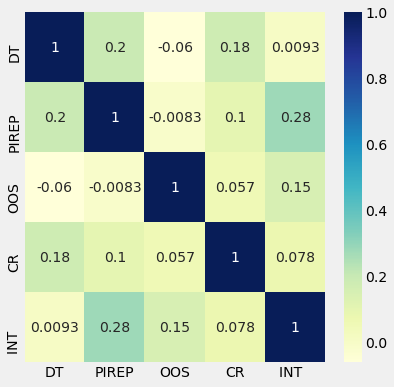

In [4]:
# HEATMAP TO CHECK MULTICOLINEARITY :: 
plt.figure(figsize=(6,6))
dfplot = sns.heatmap(df.corr(),  cmap="YlGnBu", annot=True)
plt.show()

In [5]:
df['Month_Code'] = pd.to_datetime(df['DT'],format ='%Y%m',errors = 'coerce')
df = df.iloc[:,1:]
df['OOS'].fillna(value=df.OOS.mean(), inplace=True)

In [6]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['quarter'] = df['Month_Code'].dt.quarter
    df['month'] = df['Month_Code'].dt.month
    #df['year'] = df['Month_code'].dt.year
    return df

In [7]:
T_len = 200
train=df[0:T_len]
test=df[T_len:]
print(len(train))
print(len(test))

200
59


In [8]:
print(test.shape)
print(train.shape)

(59, 5)
(200, 5)


In [9]:
train = create_features(train)
test = create_features(test)

In [10]:
features = train.iloc[:,[0,1,2,5,6]].columns
label = train.iloc[:,[3]].columns

In [11]:
x_train = train[features]
y_train = train[label]
x_test = test[features]
y_test  = test[label]

In [12]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.05,0.1],
        'max_depth': [2,3,4,5],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500,1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           
                           scoring = 'neg_mean_squared_error', 
                           cv = 2,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [13]:
parameters = hyperParameterTuning(x_train, y_train)
parameters

Fitting 2 folds for each of 576 candidates, totalling 1152 fits


{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 2,
 'min_child_weight': 5,
 'n_estimators': 200,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [13]:
param = {"booster":"gblinear", "objective":"reg:linear"}

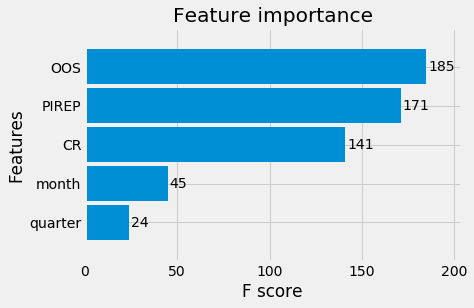

In [82]:
_ = plot_importance(reg_lin, height=0.9)

In [71]:
test['Prediction'] = reg_lin.predict(x_test)
train["Prediction"] = reg_lin.predict(x_train)
Result = pd.concat([train,test])

In [86]:
Result.columns

Index(['PIREP', 'OOS', 'CR', 'INT  ', 'Month_Code', 'quarter', 'month',
       'Prediction'],
      dtype='object')

In [2]:
# OVERALL DATA COMPARISON 

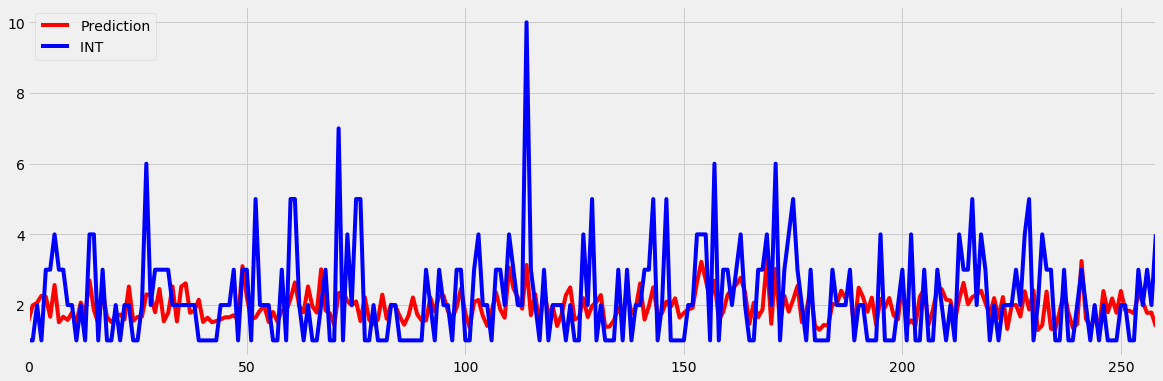

In [87]:

plt.figure(figsize=(18,6))

Result["Prediction"].plot(color = "red")
Result['INT  '].plot(color = "blue")

plt.legend(loc="upper left")

In [ ]:
# TEST DATA COMPARISON 

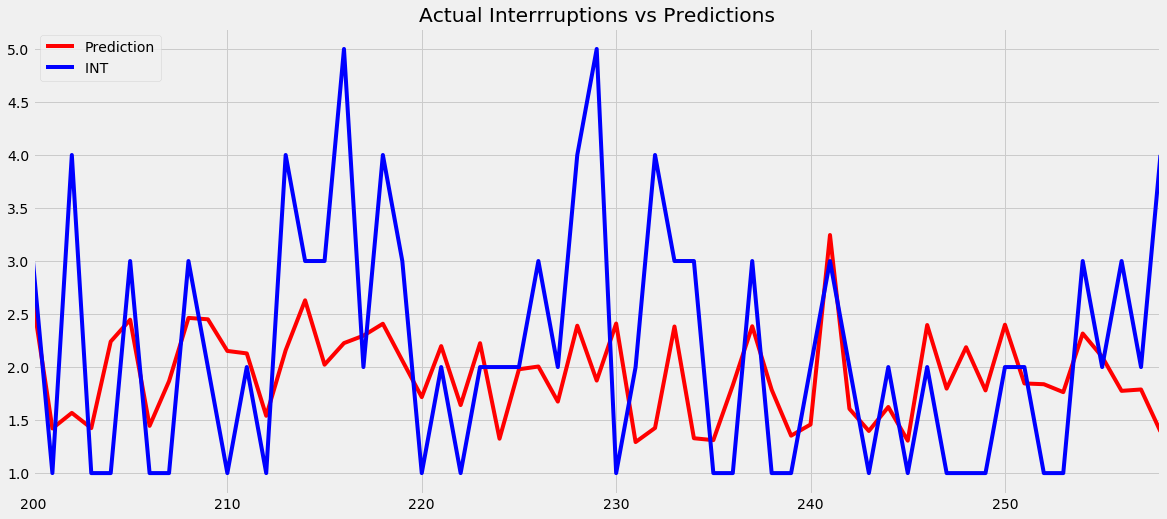

In [90]:
plt.figure(figsize=(18,8))
test["Prediction"].plot(color = "red")
test['INT  '].plot(color = "blue")
plt.title('Actual Interrruptions vs Predictions')

plt.legend(loc="upper left")

In [88]:
mean_squared_error(test[['INT  ']],
                   test['Prediction'])

1.1889717084945934

In [31]:
# Accuracvy Check : 
1-(np.abs(test['INT  '].sum()-test["Prediction"].sum())/test['INT  '].sum())

0.89154452085495

In [85]:
import lightgbm as lgb

In [91]:
params = {'boosting_type': 'gbdt', 'objective' : 'regression', 'metric' : {'12', '11'}, 'num_leaves' : 31,
          'learning_rate' : 0.05, 'feautres_fraction' : 0.9, 'bagging_fraction' : 0.8, 'bagging_freq' :5, 'verbose' : 0 }

In [ ]:
train_set = lgb.df(x_train[features],y_train)
val_set = lgb.df(x_test[features],y_test)